### Import following:
- video.py
- model.py
- MS_SSIM_L1_loss.py
- processing.py
- make `checkpoints` folder anf upload weights

In [ ]:
! pip3 install torch torchvision torchaudio
! pip3 install numpy
! pip3  install matplotlib
! pip3 install pytorch-lightning

In [2]:
import time
import os
from video import Video
from PIL import Image
from IPython.display import display
from processing import Helper
from MS_SSIM_L1_loss import MS_SSIM_L1_LOSS
import numpy as np
import matplotlib.pyplot as plt

#### Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!unzip drive/MyDrive/VIDEOS.zip

#### Set constants:

In [5]:
VIDEO = "V2"
PATH = "./VIDEOS"
FILE_TYPE = "mp4"
FULL_PATH = PATH + "/" + VIDEO + "." + FILE_TYPE
THRESHOLD = 60

#### Create 2 video objects to compare:
- using autoencoder to compress video
- not using autoencoder to compress video

In [6]:
video_autoencoder = Video(
    path=FULL_PATH, per_second_acquisition=5, use_model=True, threshold=THRESHOLD
)
video_no_autoencoder = Video(
    path=FULL_PATH, per_second_acquisition=5, use_model=False, threshold=THRESHOLD
)

frames per second of video: 30.0
start inference from epoch 50
Deblurred frames generated
Key frames generated
number of key frames to be generated per second: 77
frames per second of video: 30.0
Deblurred frames generated
Key frames generated
number of key frames to be generated per second: 12


#### Plotting differnce between consecutive frames before saving key frames

In [7]:
frames_1, _ = video_autoencoder.get_generators()
frames_2, _ = video_no_autoencoder.get_generators()
function = MS_SSIM_L1_LOSS()

In [8]:
model_1 = Helper.load_model(video_autoencoder.use_model)
diff_1, count_1 = Helper.MS_SSIM_L1_diff(frames_1, function, model_1)
model_2 = Helper.load_model(video_no_autoencoder.use_model)
diff_2, count_2 = Helper.MS_SSIM_L1_diff(frames_2, function, model_2)

start inference from epoch 50
Deblurred frames generated
loaded diffs: DONE
Deblurred frames generated
loaded diffs: DONE


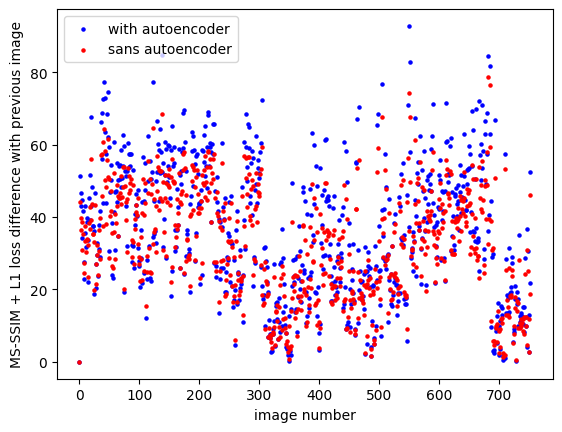

In [9]:
assert count_2 == count_1
number_frames = [i for i in range(count_1)]
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(number_frames, diff_1, label="with autoencoder", c="b", s=5)
ax1.scatter(number_frames, diff_2, label="sans autoencoder", c="r", s=5)
plt.xlabel("image number")
plt.ylabel("MS-SSIM + L1 loss difference with previous image")
plt.legend(loc="upper left")
plt.show()

#### Saving key frames in autoencoder compressed video

In [10]:
print(
    f"number of deblurred frames in video with and without autoencoder: {len(video_autoencoder)}, {len(video_no_autoencoder)}"
)
start_time = time.time()
video_autoencoder.save(directory=PATH + "/key/" + VIDEO + "/", type="key")
print(f"time to save with autoencoder:{time.time() - start_time} seconds")
start_time = time.time()
video_no_autoencoder.save(directory=PATH + "/nokey/" + VIDEO + "/", type="key")
print(f"time to save without autoencoder: {time.time() - start_time} seconds")

Deblurred frames generated
Deblurred frames generated
number of deblurred frames in video with and without autoencoder: 753, 753
start inference from epoch 50
Deblurred frames generated
Key frames generated
Saved 77 number of frames in ./VIDEOS/key/V2/
time to save with autoencoder:132.3601155281067 seconds
Deblurred frames generated
Key frames generated
Saved 12 number of frames in ./VIDEOS/nokey/V2/
time to save without autoencoder: 94.53258085250854 seconds


#### Displaying key frames of the video (with and without autoencoder)

In [12]:
folder1_path = "./VIDEOS/key/" + VIDEO + "/"
folder2_path = "./VIDEOS/nokey/" + VIDEO + "/"

folder1_files = sorted(os.listdir(folder1_path), key=Helper.key_func)
folder2_files = sorted(os.listdir(folder2_path), key=Helper.key_func)

In [ ]:
width, height = 2 * 300, 300
merged_image = Image.new("RGB", (width, height))

min_length = min(len(folder1_files), len(folder2_files))
max_length = max(len(folder1_files), len(folder2_files))

if len(folder1_files) > len(folder2_files):
  position = 0
  p = folder1_path
  f = folder1_files
else:
  position = 300
  p = folder2_path
  f = folder2_files

for i in range(min_length):
  image1 = Image.open(folder1_path + folder1_files[i])
  image1 = image1.resize((300, 300))
  merged_image.paste(image1, (0, 0))
  image2 = Image.open(folder2_path + folder2_files[i])
  image2 = image2.resize((300, 300))
  merged_image.paste(image2, (300, 0))
  print(f"image # {i+1}:")
  display(merged_image)

for i in range(min_length, max_length):
  image = Image.open(p + f[i])
  image = image.resize((300, 300))
  merged_image.paste(image, (position, 0))
  print(f"image # {i+1}:")
  display(merged_image)

In [ ]:
for i in range(min_length):
    image1 = Image.open(folder1_path + folder1_files[i]).resize((300, 300))
    image1 = np.array(image1)
    image2 = Image.open(folder2_path + folder2_files[i]).resize((300, 300))
    image2 = np.array(image2)
    print(f"image # {i+1}:")
    Helper.display_pairs(image1, image2, "using autoencoder", "without autoencoder")

for i in range(min_length, max_length):
    image = Image.open(p + f[i]).resize((300, 300))
    image = np.array(image)
    print(f"image # {i+1}:")
    if not position:
        Helper.display_pairs(image, image2, "using autoencoder", "without autoencoder")
    else:
        Helper.display_pairs(image1, image, "using autoencoder", "without autoencoder")

In [ ]:
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!zip -r VIDEOS/key/V2.zip VIDEOS/key/V2

In [ ]:
from google.colab import files

files.download("V2.zip")